<a href="https://colab.research.google.com/github/LucasFortolan/Aplicacao_K-means_E-commerce/blob/main/P2_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import kagglehub
carrie1_ecommerce_data_path = kagglehub.dataset_download('carrie1/ecommerce-data')

print('Data source import complete.')


Using Colab cache for faster access to the 'ecommerce-data' dataset.
Data source import complete.


# Aplicação de K-Means para Segmentação de Clientes

## Explicação

Este notebook demonstra como segmentar clientes de um e-commerce usando o algoritmo **K-Means**.  

O dataset contém transações de uma varejista online do Reino Unido, registradas entre **01/12/2010** e **09/12/2011**.

A empresa analisada é uma varejista sem loja física, especializada na venda de presentes exclusivos para diversas ocasiões, atendendo tanto consumidores finais quanto atacadistas.

---

## Fluxo de Análise

1. **Importação de Bibliotecas**  
   Ferramentas para manipulação de dados, clustering e visualização são carregadas.

2. **Carregamento do Dataset**  
   Cada registro representa uma transação, incluindo informações como:  
   - Cliente (`CustomerID`)  
   - Número da fatura (`InvoiceNo`)  
   - Quantidade de produtos (`Quantity`)  
   - Preço unitário (`UnitPrice`)  
   - Data da transação (`InvoiceDate`)

3. **Exploração Inicial**  
   Verifica-se o formato do dataset, colunas disponíveis e a presença de valores ausentes.

4. **Limpeza de Dados**  
   - Remoção de registros sem `CustomerID`  
   - Eliminação de duplicatas  
   - Filtragem de transações com quantidade ou preço negativo

5. **Criação de Métricas Adicionais**  
   - Conversão da coluna de datas para o formato correto  
   - Cálculo do valor total de cada compra (`TotalPrice = Quantity × UnitPrice`)

6. **Construção da Tabela RFM**  
   Para cada cliente, calcula-se:  
   - **Recência (R):** dias desde a última compra  
   - **Frequência (F):** número de compras distintas  
   - **Valor Monetário (M):** total gasto

7. **Padronização dos Dados**  
   Ajuste da média e desvio padrão das métricas RFM para evitar que variáveis com escalas diferentes influenciem o clustering.

8. **Escolha do Número de Clusters**  
   Aplicação do **método do cotovelo (Elbow Method)** para definir o número ideal de grupos com base na inércia.

9. **Aplicação do K-Means**  
   Os clientes são agrupados em clusters com comportamento semelhante.

10. **Avaliação da Qualidade dos Clusters**  
    Uso do **Silhouette Score** para medir separação e coesão dos clusters.

11. **Visualização dos Clusters**  
    Redução dimensional com **PCA** e plotagem dos clusters para interpretação visual.

12. **Visualização dos Centróides**  
    Identificação do comportamento médio de cada cluster.

13. **Indicadores dos Clusters**  
    - Cálculo das médias de RFM, número de clientes e participação na receita  
    - Identificação de perfis estratégicos:  
      - **VIP / Alta fidelidade:** compram com frequência, gastam muito e compraram recentemente  
      - **Engajados médios / Potenciais:** compram razoavelmente, gastam menos  
      - **Inativos / A recuperar:** não compram há muito tempo, gastam pouco  
      - **Baixo valor ou sazonais:** compras pontuais e baixo retorno

---

Esse pipeline permite **analisar e segmentar clientes de forma estratégica**, facilitando decisões de marketing, fidelização e direcionamento de campanhas.

## 1️ - Importar Bibliotecas

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## 2️ - Carregar o Dataset do Kaggle

In [17]:
file_path = "/kaggle/input/ecommerce-data/data.csv"
df = pd.read_csv(file_path, encoding='unicode_escape')
df.head(100)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
95,536378,22352,LUNCH BOX WITH CUTLERY RETROSPOT,6,12/1/2010 9:37,2.55,14688.0,United Kingdom
96,536378,21212,PACK OF 72 RETROSPOT CAKE CASES,120,12/1/2010 9:37,0.42,14688.0,United Kingdom
97,536378,21975,PACK OF 60 DINOSAUR CAKE CASES,24,12/1/2010 9:37,0.55,14688.0,United Kingdom
98,536378,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,12/1/2010 9:37,0.55,14688.0,United Kingdom


## 3️ - Explorar Dados Iniciais

In [18]:
print("Formato do dataset:", df.shape)
print("\nColunas disponíveis:\n", df.columns)
print("\nValores ausentes por coluna:\n", df.isnull().sum())

Formato do dataset: (541909, 8)

Colunas disponíveis:
 Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Valores ausentes por coluna:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## 4 - Criar uma Cópia e Remover Dados Ausentes

In [19]:
df_segments = df.dropna(subset=['CustomerID']).copy()
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


## 5️ - Limpeza de Dados — Remover Duplicatas e Valores Inválidos

In [20]:
# Remover duplicatas
df_segments = df_segments.drop_duplicates()

# Filtrar quantidades e preços negativos
df_segments = df_segments[(df_segments['Quantity'] > 0) & (df_segments['UnitPrice'] > 0)]

print("Após limpeza:", df_segments.shape)
print("Quantidade de Clientes Únicos:", df['CustomerID'].nunique())

Após limpeza: (392692, 8)
Quantidade de Clientes Únicos: 4372


## 6️ - Criar Coluna de Valor Total e Converter Datas

In [21]:
df_segments['InvoiceDate'] = pd.to_datetime(df_segments['InvoiceDate'])
df_segments['TotalPrice'] = df_segments['Quantity'] * df_segments['UnitPrice']
df_segments.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## 7️ - Construir Tabela RFM (Recência, Frequência, Valor Monetário)

In [22]:
# Data de referência: 1 dia após a última compra registrada
        #  maior data de compra
ref_date = df_segments['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df_segments.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recência
    'InvoiceNo': 'nunique',                             # Frequência
    'TotalPrice': 'sum'                                 # Valor Monetário
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## 8️ - Padronizar Dados (StandardScaler)

In [23]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.334574,-0.425097,8.363010
12347.0,-0.905340,0.354417,0.251699
12348.0,-0.175360,-0.035340,-0.027988
12349.0,-0.735345,-0.425097,-0.032406
12350.0,2.174578,-0.425097,-0.190812


## 9 - Escolher o Número Ideal de Clusters — Método do Cotovelo (Elbow Method)

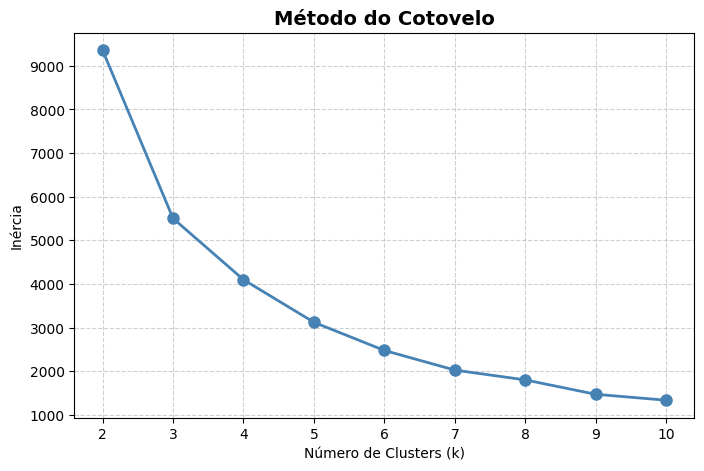

In [24]:
inertia = []
K = range(2, 11)  # Testando de 2 a 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot do Método do Cotovelo
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'o-', color='steelblue', linewidth=2, markersize=8)
plt.title('Método do Cotovelo', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 10 - Aplicar o Algoritmo K-Means

In [25]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,3
12347.0,2,7,4310.00,0
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,1


## 11 - Avaliar a Qualidade dos Clusters (Silhouette Score)

In [26]:
silhouette_avg = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")

Silhouette Score: 0.616


## 1️2 - Visualizar os Clusters

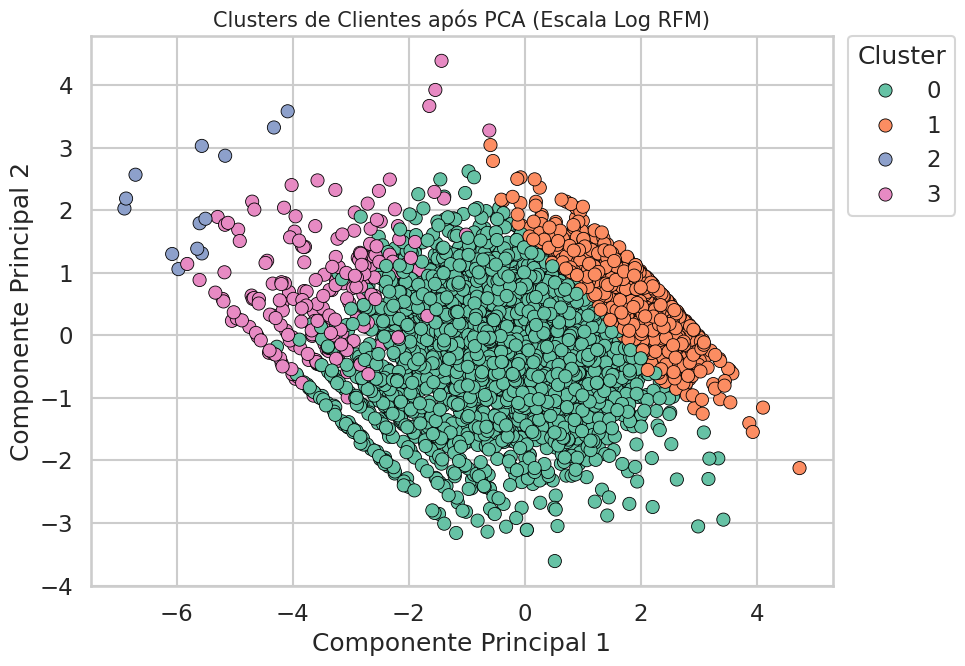

In [27]:
# === Criar versão log-transformada do RFM para reduzir skew ===
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_log = pd.DataFrame(rfm_log, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])

# Adicionar a coluna de cluster para visualização
rfm_log['Cluster'] = rfm['Cluster'].values

# === Redução Dimensional com PCA ===
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])
rfm_log['PCA1'] = rfm_pca[:, 0]
rfm_log['PCA2'] = rfm_pca[:, 1]

# === Visualização dos clusters após PCA ===
plt.figure(figsize=(10, 7))
sns.set(style='whitegrid', context='talk')

scatter = sns.scatterplot(
    data=rfm_log,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='Set2',
    s=90,
    edgecolor='black',
    linewidth=0.6,
)

plt.title('Clusters de Clientes após PCA (Escala Log RFM)', fontsize=15)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Legenda formatada fora da área do gráfico
plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
)

plt.tight_layout()
plt.show()

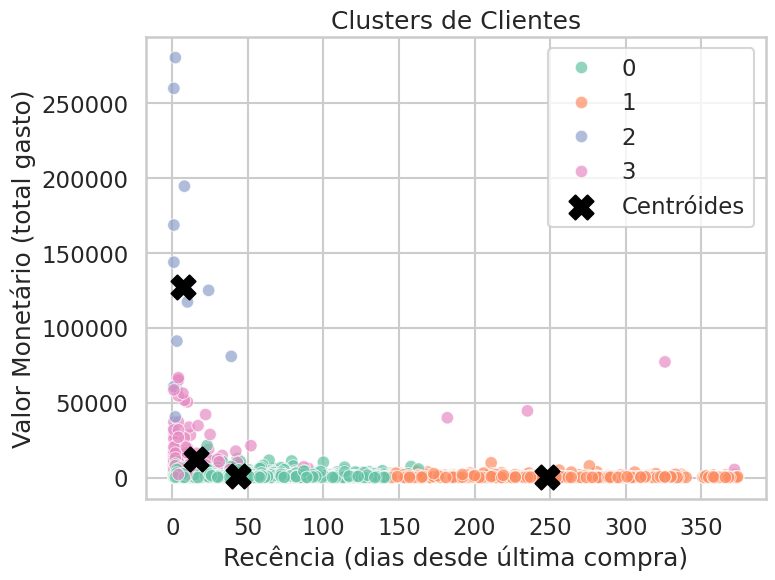

In [28]:
# Inverter a padronização dos centróides
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

# Criar gráfico com centróides nas escalas corretas
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x='Recency', y='Monetary',
    hue='Cluster',
    palette='Set2', alpha=0.7
)

# Adicionar centróides
plt.scatter(
    centroids_original[:, 0],  # Recency
    centroids_original[:, 2],  # Monetary
    s=300, c='black', marker='X', label='Centróides'
)

plt.title('Clusters de Clientes')
plt.xlabel('Recência (dias desde última compra)')
plt.ylabel('Valor Monetário (total gasto)')
plt.legend()
plt.show()

## 13 - Indicadores dos Clusters

In [29]:
# Tabela de resumo (médias)
rfm_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

# Número e % de clientes por cluster
rfm_summary['Clientes'] = rfm['Cluster'].value_counts().sort_index()
rfm_summary['% Clientes'] = (rfm_summary['Clientes'] / len(rfm) * 100).round(2)

# 🔹 Adicionar valor total gerado por cada cluster
rfm_summary['Valor Total (£)'] = rfm.groupby('Cluster')['Monetary'].sum().round(2)

# 🔹 Calcular % de participação no faturamento
rfm_summary['% Receita'] = (rfm_summary['Valor Total (£)'] / rfm['Monetary'].sum() * 100).round(2)

# 🔹 Calcular frequência média anual aproximada (dados entre dez/2010 e dez/2011 → 1 ano)
rfm_summary['Freq. Média (ano)'] = rfm_summary['Frequency'].round(1)

# Reorganizar colunas
rfm_summary = rfm_summary[['Clientes', '% Clientes', 'Recency', 'Freq. Média (ano)', 'Monetary', 'Valor Total (£)', '% Receita']]

# 🔹 Adicionar linha de total geral
total_row = pd.DataFrame({
    'Clientes': [rfm_summary['Clientes'].sum()],
    '% Clientes': [rfm_summary['% Clientes'].sum()],
    'Recency': [rfm_summary['Recency'].mean()],
    'Freq. Média (ano)': [rfm_summary['Freq. Média (ano)'].mean()],
    'Monetary': [rfm['Monetary'].mean()],
    'Valor Total (£)': [rfm['Monetary'].sum()],
    '% Receita': [100.00]
}, index=['Total'])

# Concatenar
rfm_summary = pd.concat([rfm_summary, total_row])

# 🔹 Formatar colunas monetárias com símbolo (£)
rfm_summary['Monetary'] = rfm_summary['Monetary'].apply(lambda x: f"£{x:,.2f}")
rfm_summary['Valor Total (£)'] = rfm_summary['Valor Total (£)'].apply(lambda x: f"£{x:,.2f}")

# Exibir tabela formatada
display(rfm_summary)

# Interpretação automática
for cluster, row in rfm_summary.iloc[:-1].iterrows():  # evita interpretar a linha 'Total'
    print(f"\nCluster {cluster}")
    print(f"Clientes: {row['Clientes']} ({row['% Clientes']}%)")
    print(f"Recência média: {row['Recency']} dias, Frequência média anual: {row['Freq. Média (ano)']}, Valor médio: {row['Monetary']}")
    print(f"Valor total gerado: {row['Valor Total (£)']} ({row['% Receita']}% da receita total)")

    # Interpretação baseada no comportamento
    rec = float(rfm.groupby('Cluster')['Recency'].mean()[cluster])
    freq = float(rfm.groupby('Cluster')['Frequency'].mean()[cluster])
    mon = float(rfm.groupby('Cluster')['Monetary'].mean()[cluster])
    if rec < rfm['Recency'].mean() and freq > rfm['Frequency'].mean() and mon > rfm['Monetary'].mean():
        print("Perfil: Clientes VIP / Alta Fidelidade — compram com frequência, gastam muito e são recentes.")
    elif freq >= rfm['Frequency'].mean() and mon <= rfm['Monetary'].mean():
        print("Perfil: Clientes Potenciais / Engajados Médios — compram razoavelmente, mas com valor menor.")
    elif rec > rfm['Recency'].mean() and freq < rfm['Frequency'].mean():
        print("Perfil: Clientes Inativos / A Recuperar — não compram há muito tempo e gastam pouco.")
    else:
        print("Perfil: Clientes de Baixo Valor ou Sazonais — compras pontuais e baixo retorno.")

# Total de clientes únicos no dataset completo
clientes_total = df['CustomerID'].nunique()

# Total de clientes usados no modelo RFM
rfm = rfm.reset_index()
clientes_rfm = rfm['CustomerID'].nunique()

# Clientes não incluídos na clusterização
clientes_fora = clientes_total - clientes_rfm

print(f"\n\nClientes únicos totais: {clientes_total}")
print(f"Clientes usados no RFM: {clientes_rfm}")
print(f"Clientes fora do modelo: {clientes_fora}")

,Clientes,% Clientes,Recency,Freq. Média (ano),Monetary,Valor Total (£),% Receita
0,3054,70.4,43.700,3.700,"£1,353.63","£4,133,971.70",46.52
1,1067,24.6,248.080,1.600,£478.85,"£510,931.64",5.75
2,13,0.3,7.380,82.500,"£127,187.96","£1,653,443.47",18.60
3,204,4.7,15.500,22.300,"£12,690.50","£2,588,862.08",29.13
Total,4338,100.0,78.665,27.525,"£2,048.69","£8,887,208.89",100.00



Cluster 0
Clientes: 3054 (70.4%)
Recência média: 43.7 dias, Frequência média anual: 3.7, Valor médio: £1,353.63
Valor total gerado: £4,133,971.70 (46.52% da receita total)
Perfil: Clientes de Baixo Valor ou Sazonais — compras pontuais e baixo retorno.

Cluster 1
Clientes: 1067 (24.6%)
Recência média: 248.08 dias, Frequência média anual: 1.6, Valor médio: £478.85
Valor total gerado: £510,931.64 (5.75% da receita total)
Perfil: Clientes Inativos / A Recuperar — não compram há muito tempo e gastam pouco.

Cluster 2
Clientes: 13 (0.3%)
Recência média: 7.38 dias, Frequência média anual: 82.5, Valor médio: £127,187.96
Valor total gerado: £1,653,443.47 (18.6% da receita total)
Perfil: Clientes VIP / Alta Fidelidade — compram com frequência, gastam muito e são recentes.

Cluster 3
Clientes: 204 (4.7%)
Recência média: 15.5 dias, Frequência média anual: 22.3, Valor médio: £12,690.50
Valor total gerado: £2,588,862.08 (29.13% da receita total)
Perfil: Clientes VIP / Alta Fidelidade — compram com 